## Acquiring NOAA'S GOES-16 ABI Aerosol Optical Depth from Amazon S3 and Mapping the Images

In the past few years the availability of remotely sensed satellite imagery products has immensely increased, greatly accompanied by an increase in spatial, temporal, and spectral resolutions. Due to their large data size, requirement for storage and processing power, and continuously changing data nature, researchers have been facing challenges to mine information from these invaluable data resources. Cloud storage platforms and high-performance computing (HPC) facilities have been playing a great role in addressing some of these constraints by making the accessibility of the datasets easier and more efficient. Founded on these ambitions, the Amazon S3 cloud storage platform provides very big satellite data products from different institutions including NOAA and NASA, and working environment for exploring, processing, and analyzing. To take advantage of these resources, I have developed a Python script that reads, processes, and maps NOAA’s GOES-16 ABI aerosol optical depth (AOD), without downloading the data.

This Python notebook shows the acquisition of GOES-16 (East) Advanced Baseline Imager Level Aerosol Optical Depth (AOD) from the Amazon S3 simple storage service, exploration of the variables and attributes of the images, and mapping of the images. It demonstrates the acquisition of images from cloud storage and, processing and mapping of the acquired images in Python notebook without downloading to local computer. Here, I used the ABI-L2_AODC (Advanced Baseline Imager Level 2 Aerosol Optical Depth CONUS) images covering the CONUS region, scanned on March 27, 2020. This product has a horizontal spatial resolution of 2.0 km at nadir and termporal resolution of 5 minutes ([NOAA's GOES Proudct Users' Guide](https://goes-r.gov/products/docs/PUG-L2+-vol5.pdf)). 

### Required libraries

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import numpy as np
import requests
import boto3
import datetime 
from IPython.display import Image

%matplotlib inline

### Navigating from N/S Elevation Angle (y) and E/W Scanning Angle (x) to Geodetic Latitude (φ) and Longitude (λ)

<div align="center">
  <img width="500" height="500" src="Images/Coordinate_Frames_ABI_Fixed_Grid_Navigation.png">
</div>

Given a point P on the GRS80 ellipsoid with fixed grid coordinates (y,x), the geodetic latitude ($ \phi $) and longitude ($ \lambda $) can be computed by the following relationships provided in GOES-R SERIES PRODUCT DEFINITION AND USERS’ GUIDE ([NOAA's GOES Proudct Users' Guide](https://goes-r.gov/products/docs/PUG-L2+-vol5.pdf)):

$$
\phi = arctan\left( \frac{r_{eq}^2}{r_{pol}^2} \frac{s_{z}}{\sqrt{\left(H - s_x \right)^2 + s_y^2}} \right)\\\\\\
$$ 

$$
\lambda = \lambda_0 - arctan\left(\frac{s_y}{H - s_x} \right)
$$

where: 

$$
r_{eq} = radius \: of \: Earth \: at \: the \: equator
$$

$$
r_{pol} = radus \: of \: Earth \: at \: the \: pole
$$  

$$
H = distance \: from \: satellite \: to \: Earth \: center\\
$$

$$
\lambda_0 = longitude \: of \: projection \: origin\\
$$

$$
s_x, s_y, s_z = derived \: using \: satellite \: location \: and \: earth \: geometry
$$

The coordinate rotations ($ s_x, s_y, \: and \: s_z $) are defined as follows:

$$
s_x = r_{s}cos(x)cos(y)
$$

$$
s_y = -r_{s}sin(x)
$$

$$
s_z = r_{s}cos(x)sin(y)
$$

The x and y are the fixed grid East/West and North/South scan angles in radians, respectively, given in the netCDF data file. Further, $ r_s $ which is distane from the satellite to point P is calculated using the quadratic formula as follows:

$$
r_s = \frac{-b - \sqrt{b^2 - 4ac}}{2a}
$$

The variables a, b, and c are defined as:

$$
a = sin^2{(x)} + cos^2{(x)}\left(cos^2{(y)} + {\frac{r_{eq}^2}{r_{pol}^2}}sin^2{(y)} \right)
$$

$$
b = -2Hcos(x)cos(y)
$$

$$
c = H^2 - r_{eq}^2
$$

### Acquiring GOES-16 ABI (East) images from Amazon S3

In [2]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L2-AODC' #Advanced Baseline Imager Level 2 Aerosol Optical Depth CONUS
year = 2020
day_of_year = 87 
hour = 15

#### Accessing the images through the AWS CLI credentials

In [3]:
s3_client = boto3.client('s3',
                         aws_access_key_id = 'YOUR_AWS_ACCESS_KEY_ID',
                         aws_secret_access_key = 'YOUR_AWS_SECRET_ACCESS_KEY')

In [4]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [5]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}')

In [6]:
keys_combined = []
for i in keys:
    keys_combined.append(i)
    
print(keys_combined)
print('Length of Keys is {}'.format(len(keys_combined)))

['ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871501184_e20200871503557_c20200871507290.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871506184_e20200871508557_c20200871512234.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871511184_e20200871513557_c20200871517166.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871516184_e20200871518557_c20200871522171.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871521184_e20200871523557_c20200871527173.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871526184_e20200871528557_c20200871532199.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871531184_e20200871533557_c20200871537214.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871536184_e20200871538557_c20200871542252.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871541184_e20200871543557_c20200871547209.nc', 'ABI-L2-AODC/2020/087/15/OR_ABI-L2-AODC-M6_G16_s20200871546184_e20200871548557_c20200871552194.nc',

### Mapping the images

/Users/iyasueibed/anaconda3/envs/geo_spatial_env/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt
/Users/iyasueibed/anaconda3/envs/geo_spatial_env/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt


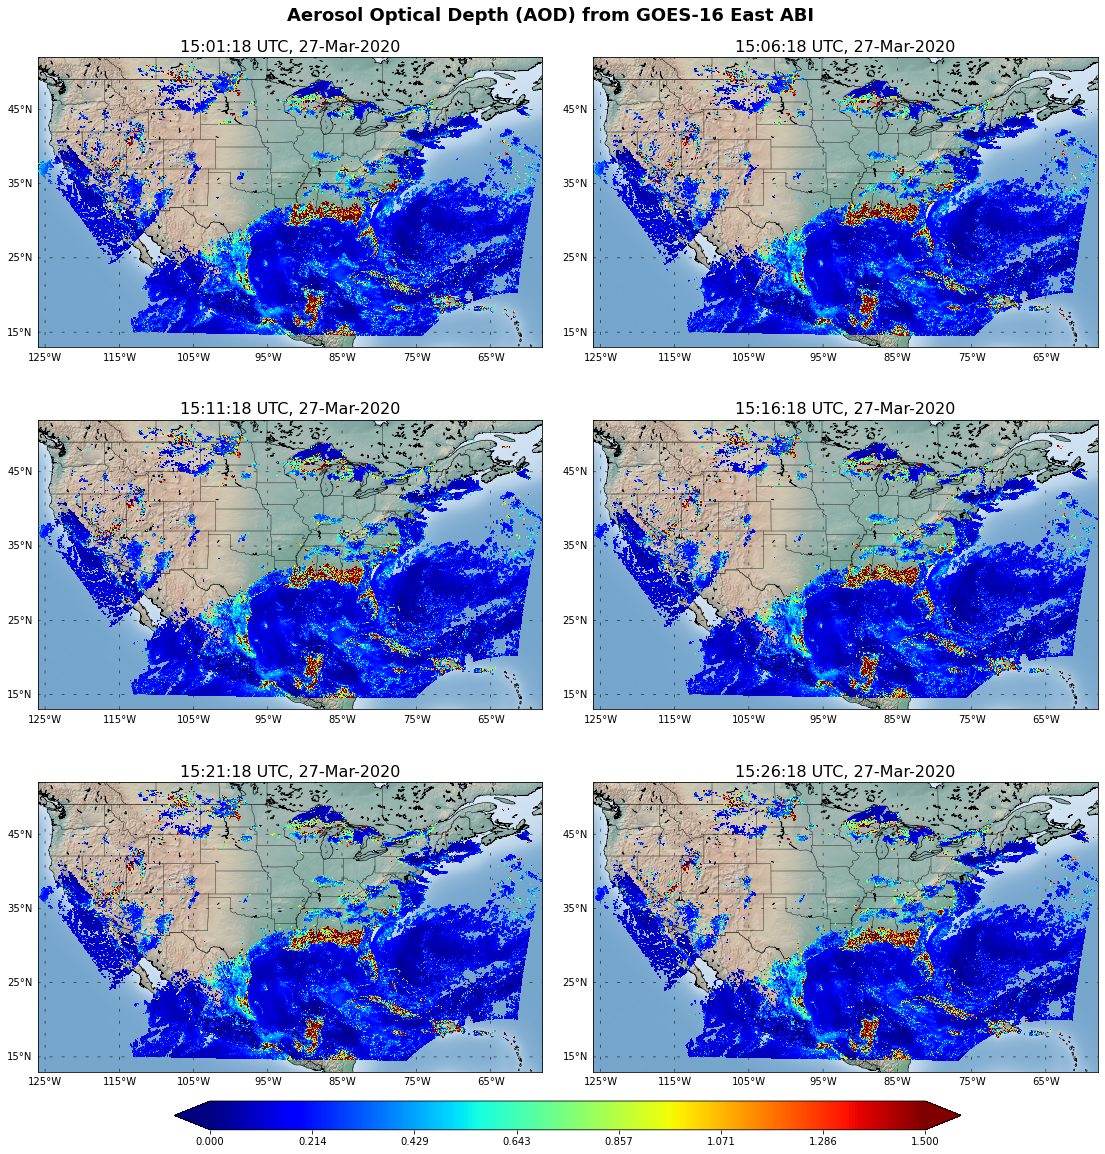

In [7]:
fig, axes = plt.subplots(3,2, figsize=(19,20))#(width,height)
fig.subplots_adjust(hspace=0, wspace=0.1)

axes = axes.ravel()

for i, ax in enumerate(axes):
    
    single_file = keys_combined[i]
    file_name = single_file.split('/')[-1].split('.')[0]
    
    ## Search for the Scan start in the file name
    start = (file_name[file_name.find("_s")+2:file_name.find("_e")])
    
    ## Converting from julian day to dd-mm-yyyy
    year = int(start[0:4])
    dayjulian = int(start[4:7]) - 1 # Subtract 1 because the year starts at "0"
    dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
    date = dayconventional.strftime('%d-%b-%Y')  # Format the date according to the strftime directives
    time = start [7:9] + ":" + start [9:11] + ":" + start [11:13] + " UTC" # Time of the Start of the Scan
        
    ## Response from AWS S3
    resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{single_file}')
    
    ## Open the file using the NetCDF4 library
    nc = Dataset(file_name, memory = resp.content)
    
    ## Parameters required to naviage data points on ABI fixed grid
    x_rad_1d = nc.variables['x'][:]
    y_rad_1d = nc.variables['y'][:]
    x_rad,y_rad = np.meshgrid(x_rad_1d,y_rad_1d)
    AOD_550nm = nc.variables['AOD'][:]
    
    ## GOES-R projection info and retrieving relevant constants
    variable_req = nc.variables['goes_imager_projection']
    lambda_0 = (variable_req.longitude_of_projection_origin)*(np.pi/180)
    H = variable_req.perspective_point_height + variable_req.semi_major_axis
    r_eq = variable_req.semi_major_axis
    r_pol = variable_req.semi_minor_axis
    
    # close file when finished
    nc.close()
    nc = None
    
    ## Navigate from N/S elevstion sngle (y) and E/W scanning angle (x) to geodetic latitue and longitude
    a_var = np.power((np.sin(x_rad)),2) + (np.power((np.cos(x_rad)),2)*(np.power((np.cos(y_rad)),2)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_rad),2))))
    b_var = (-2.0*H)*(np.cos(x_rad)*np.cos(y_rad))
    c_var = (H**2)-(r_eq**2)

    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var) #Distance from the satellite to point P in the ground surface

    s_x = r_s*np.cos(x_rad)*np.cos(y_rad)
    s_y = -1 * r_s * np.sin(x_rad)
    s_z = r_s*np.cos(x_rad)*np.sin(y_rad)
    
    ## Latitude and longitude projection for plotting data on traditional lat/lon maps    
    lat = (np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))*(180.0/np.pi)
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    data_bounds = np.where(AOD_550nm.data!=65535)
    bbox = [np.min(lon[data_bounds]),
            np.min(lat[data_bounds]),
            np.max(lon[data_bounds]),
            np.max(lat[data_bounds])] 
    
    n_add = 0 # for zooming in and out
    m = Basemap(ax = axes[i],llcrnrlon=-126-n_add,llcrnrlat=13-n_add,urcrnrlon=-58+n_add,\
                urcrnrlat=52+n_add,resolution='i', projection='cyl')
    
    m.shadedrelief()
    m.drawcoastlines(color='black',linewidth=0.6)
    m.drawcountries(color='black',linewidth=0.6)
    m.drawstates(color='black',linewidth=0.2)
    
    vmin = 0
    vmax = 1.5 #np.nanmax(AOD_550nm[:])
    set_1 = m.pcolormesh(lon.data, lat.data, AOD_550nm, latlon=True,zorder=999, cmap = "jet",vmin=vmin, vmax=vmax)
    title_name = time + ', ' + date
    ax.set_title(title_name,fontsize=16) 
    
    del AOD_550nm
    
    parallels = np.arange(15,60,10.);
    meridians = np.arange(-125,-60,10.); 
    m.drawparallels(parallels,linewidth=0.5,labels=[1,0,0,0],fontsize=10,dashes=[6, 18]);
    m.drawmeridians(meridians,linewidth=0.5,labels=[0,0,0,1],fontsize=10,dashes=[6, 18]);
    
p0 = axes[4].get_position().get_points().flatten()
p1 = axes[5].get_position().get_points().flatten()   
ax_cbar = fig.add_axes([p0[0]+0.1, 0+0.11, p1[2]-p0[0]-0.2, 0.02])
ticks = np.linspace(vmin, vmax, 8)
cb=plt.colorbar(set_1,cax=ax_cbar,extend='both', orientation='horizontal',ticks=ticks) 
 
plt.suptitle("Aerosol Optical Depth (AOD) from GOES-16 East ABI", fontsize=18, fontweight='bold', y=0.89)
plt.savefig('output/GOES_ABI_AOD.png', bbox_inches = 'tight')
plt.show()   